<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Initialization" data-toc-modified-id="Initialization-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Initialization</a></span><ul class="toc-item"><li><span><a href="#Imports---start-here" data-toc-modified-id="Imports---start-here-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Imports - start here</a></span></li><li><span><a href="#Define-variables-for-experiment" data-toc-modified-id="Define-variables-for-experiment-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Define variables for experiment</a></span></li><li><span><a href="#Download-data-set" data-toc-modified-id="Download-data-set-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Download data set</a></span></li></ul></li><li><span><a href="#Training" data-toc-modified-id="Training-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#See-prediction" data-toc-modified-id="See-prediction-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>See prediction</a></span></li></ul></div>

# 101 EfficientNet Image Classification


To perform the training we are using the following technologies:
* **S3 bucket** as mounted a file system [here](../bucket): this is place for all training artifacts. Keras prefers to work with the artifacts as it would be normal files.
* **Notebook profile** [here](profile_default/startup) contains meaningful notebook defaults and settings
* **SuperHub integration** contains various environment provisioning scripts 
* **Git integration** your notebook has a git repository. It is wise to make periodical commits into the git. Best way to do it is to use Jupyter terminal

## Initialization

In [20]:
!pip install git+git://github.com/SemanticMD/efficientnet_keras_transfer_learning

  Cloning git://github.com/SemanticMD/efficientnet_keras_transfer_learning to /tmp/pip-req-build-ff8rw_wv
  Running command git clone -q git://github.com/SemanticMD/efficientnet_keras_transfer_learning /tmp/pip-req-build-ff8rw_wv
  Created wheel for efficientnet: filename=efficientnet-0.0.3-cp36-none-any.whl size=11741 sha256=07f85bad3fb075176d9211e4af75a9d8405777e8fffd2199c750b035ad4a250c
  Stored in directory: /tmp/pip-ephem-wheel-cache-m7dk5ewu/wheels/88/49/79/7d9644fae698f704d32d968ef611188000ae32a547721cfc85
Successfully built efficientnet
You should consider upgrading via the 'pip install --upgrade pip' command.


In [ ]:
!pip install scikit-image

In [3]:
!pip install tensorflow==1.15.0

You should consider upgrading via the 'pip install --upgrade pip' command.


In [ ]:
!pip install minio

In [9]:
!pip install pixiedust

You should consider upgrading via the 'pip install --upgrade pip' command.


### Imports - start here

In [21]:
import pixiedust

In [19]:
tf.VERSION

NameError: name 'tf' is not defined

In [22]:
import logging
import os
# reduce tensorflow warnings in logs
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tempfile
import glob
import shutil
import pandas as pd
from datetime import datetime
import itertools
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import TensorBoard

from minio import Minio
from minio.error import ResponseError

# Options: EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3
# Higher the number, the more complex the model is.
from efficientnet import EfficientNetB0 as Net
from efficientnet import center_crop_and_resize, preprocess_input
from efficientnet.layers import Swish, DropConnect
from efficientnet.model import ConvKernalInitializer


In [23]:
%reload_ext autoreload
%autoreload 2

%reload_ext nbextensions
%load_nbvars

import kfp.dsl as dsl
import kfp.gcp as gcp
import pandas as pd
from ipython_secrets import get_secret
from kfp.compiler import Compiler
from kfp.components import load_component_from_file
from os import environ
import boto3, kfp

from nbextensions.pv import use_pvc
from nbextensions.kubernetes import dockerjson_pv
from nbextensions.aws import upload_to_s3

import nbextensions.utils as utils
from datetime import datetime
from urllib.parse import urlparse

import warnings
warnings.filterwarnings('ignore')

from utils import (get_value, get_value_as_int, get_value_as_float, copy)

Loading notebook variables from configmap: `kubeflow/efficientnet1-nb-vars`

All notebook variables has been already loaded

In [9]:
%load_ext autoreload
%autoreload 2
from os import environ, makedirs
from nbextensions.utils import download_file

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Define variables for experiment
In the beginning of the scrip we define all necessary variables. We have a single cell to define all experiment configuration in one place.

In [51]:
## Globals
# TODO: remove this
REMOTE_MINIO_SERVER = get_secret('REMOTE_MINIO_SERVER')
ACCESS_KEY = get_secret('ACCESS_KEY')
SECRET_KEY = get_secret('SECRET_KEY')

DATASET_DIR = f"{environ['HOME']}/data/santosh-test/datasets"

FILETYPES = ('*.jpg', '*.jpeg', '*.png')
MODEL_VERSION='1'
MODEL_FNAME='pneumothorax_'  + datetime.now().strftime("%m_%d_%S") + '.h5'
DATASET_NAME='normal_pneumothorax'
LABELS='normal,pneumothorax'

LOG_DIR = os.getenv('LOG_DIR') or '/logs'
tensorboard_callback = TensorBoard(log_dir=LOG_DIR)

In [49]:
TAG = '1'

ARTIFACTS_ROOT = f"{environ['HOME']}/data/training-{TAG}"
TEST_IMAGE_DIR = f"{environ['HOME']}/data/test"
TEST_IMAGE_FILE = f"{ARTIFACTS_ROOT}/panda.jpg"
MODEL_FILE = f"{environ['HOME']}/data/models/{MODEL_VERSION}/{MODEL_FNAME}"
MODEL_DIR = f"{environ['HOME']}/data/models"

In [34]:
print (f"Local dataset: {DATASET_DIR}")
print (f"Remote dataset: REMOTE_MINIO_SERVER {REMOTE_MINIO_SERVER}")
print (f"Test image: {TEST_IMAGE_FILE}")
print (f"Model file: {MODEL_FILE}")

Local dataset: /home/jovyan/data/santosh-test/datasets
Remote dataset: REMOTE_MINIO_SERVER 206.189.86.150:32782
Test image: /home/jovyan/data/training-1/panda.jpg
Model file: /home/jovyan/data/models/1/pneumothorax_03_07_17.h5


### Download data set 

Before we start training we need to download training data from a remote server.


In [8]:
#%%pixie_debugger
def download_data(dataset_dir, dataset_name, labels):
    # create local directories
    os.makedirs(dataset_dir, exist_ok=True)
    os.makedirs(os.path.join(dataset_dir, dataset_name), exist_ok=True)    
    for x in labels.split(','):
        os.makedirs(os.path.join(dataset_dir, dataset_name, x), exist_ok=True)
    
    print('Connecting to Minio')
    # connect to remote minio server for downloading files
    mc_remote = Minio(REMOTE_MINIO_SERVER,
                      access_key=ACCESS_KEY,
                      secret_key=SECRET_KEY,
                      secure=False)

    objects = mc_remote.list_objects('datasets', prefix=dataset_name,
                                  recursive=True)
    print(dataset_name)
    for obj in objects:
        try:
            data = mc_remote.get_object('datasets', obj.object_name)
            with open(os.path.join(dataset_dir, obj.object_name), 'wb') as file_data:
                for d in data.stream(32*1024):
                    file_data.write(d)
        except ResponseError as err:
            print(err)

    return True
download_data(DATASET_DIR,DATASET_NAME,LABELS)

Connecting to Minio
normal_pneumothorax


MaxRetryError: HTTPConnectionPool(host='206.189.86.150', port=32782): Max retries exceeded with url: /datasets?location= (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fb5c9c7ce10>: Failed to establish a new connection: [Errno 110] Connection timed out',))

## Training

Uncomment %%pixie_debugger to train in debug mode

In [37]:
#%%pixie_debugger

def download_data(dataset_dir, dataset_name, labels):
    # create local directories
    os.makedirs(dataset_dir, exist_ok=True)
    os.makedirs(os.path.join(dataset_dir, dataset_name), exist_ok=True)    
    for x in labels.split(','):
        os.makedirs(os.path.join(dataset_dir, dataset_name, x), exist_ok=True)
    
    # connect to remote minio server for downloading files
    mc_remote = Minio(REMOTE_MINIO_SERVER,
                      access_key=ACCESS_KEY,
                      secret_key=SECRET_KEY,
                      secure=False)

    objects = mc_remote.list_objects('datasets', prefix=dataset_name,
                                  recursive=True)
    for obj in objects:
        try:
            data = mc_remote.get_object('datasets', obj.object_name)
            with open(os.path.join(dataset_dir, obj.object_name), 'wb') as file_data:
                for d in data.stream(32*1024):
                    file_data.write(d)
        except ResponseError as err:
            print(err)

    return True

    
def read_input(original_dataset_dir, dataset_name, labels, test_size=0.2):
    """Read input data and split it into train and test."""
    
    # download dataset if it doesn't exist
    if not os.path.exists(original_dataset_dir):
        rv = download_data(original_dataset_dir, dataset_name, labels)
    
    cat_images_list = []
    labels_list = []
    for cat in labels:
        cat_images = [glob.glob(os.path.join(original_dataset_dir,cat,e)) for e in FILETYPES]  
        cat_images = list(itertools.chain(*cat_images))
        print("total " + cat + " images: {}".format(len(cat_images)))
        labels_list += [cat]*len(cat_images)
        cat_images_list.append(cat_images)

    all_images_list = list(itertools.chain(*cat_images_list))
    
    assert len(all_images_list) == len(labels_list)

    X_train, X_test, y_train, y_test = train_test_split(
        all_images_list, labels_list, test_size=test_size, random_state=1)

    num_train = len(X_train)
    num_test = len(X_test)

    train_df = pd.DataFrame({
        'filename': X_train,
        'label': y_train
    })

    val_df = pd.DataFrame({
        'filename': X_test,
        'label': y_test
    })

    return train_df, val_df

def train_model(original_dataset_dir,
                train_df,
                val_df,
                height,
                width,
                batch_size,
                dropout_rate,
                epochs,
                learning_rate):
    """Train the model using EfficientNet."""
    input_shape = (height, width, 3)

    num_train = len(train_df.index)
    num_test = len(val_df.index)

    # loading pretrained conv base model
    conv_base = Net(weights='imagenet', include_top=False, input_shape=input_shape)

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

    # Note that the validation data should not be augmented!
    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_dataframe(
            dataframe=train_df,
            directory=original_dataset_dir,
            x_col="filename",
            y_col="label",
            target_size=(height, width),
            batch_size=batch_size,
            class_mode='categorical')

    validation_generator = test_datagen.flow_from_dataframe(
                dataframe=val_df,
                directory=original_dataset_dir,
                x_col="filename",
                y_col="label",
                target_size=(height, width),
                batch_size=batch_size,
                class_mode='categorical')

    model = models.Sequential()
    model.add(conv_base)
    model.add(layers.GlobalMaxPooling2D(name="gap"))
    # model.add(layers.Flatten(name="flatten"))
    if dropout_rate > 0:
        model.add(layers.Dropout(dropout_rate, name="dropout_out"))
    # model.add(layers.Dense(256, activation='relu', name="fc1"))
    model.add(layers.Dense(2, activation='softmax', name="fc_out"))

    conv_base.trainable = False

    model.compile(loss='categorical_crossentropy',
                optimizer=optimizers.RMSprop(lr=learning_rate),
                metrics=['acc'])
    print('Training model...')
    history = model.fit_generator(
        train_generator,
        steps_per_epoch= num_train //batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps= num_test //batch_size,
        verbose=1)        #        callbacks=[tensorboard_callback],
#         use_multiprocessing=True,
#         workers=4)


    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_x = range(len(acc))

    conv_base.trainable = True

    set_trainable = False
    for layer in conv_base.layers:
        if layer.name == 'multiply_16':
            set_trainable = True
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False

    model.compile(loss='categorical_crossentropy',
                optimizer=optimizers.RMSprop(lr=2e-5),
                metrics=['acc'])

    history = model.fit_generator(
        train_generator,
        steps_per_epoch= num_train //batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps= num_test //batch_size,
        verbose=1)

    return model

def eval_model(model, test_X, test_y):
    """Evaluate the model performance."""
    get_custom_objects().update({
        'ConvKernalInitializer': ConvKernalInitializer,
        'Swish': Swish,
        'DropConnect':DropConnect
    })
    predictions = model.predict(test_X)

def save_model(model, model_version, model_fname):
    """Save model for serving."""

    print('Saving model to remote...')
    mc_remote = Minio(REMOTE_MINIO_SERVER,
                  access_key=ACCESS_KEY,
                  secret_key=SECRET_KEY,
                  secure=False)

    logging.info("Model export success: %s", model_fname)
#    with tempfile.NamedTemporaryFile(suffix='.h5') as fp:
#        model.save(fp.name)
#        try:
#            print(mc_remote.fput_object('models', os.path.join(model_version, model_fname),fp.name))
#        except ResponseError as err:
#            print(err)

    print('Saving model to local...')
    # Workaround because of: at present goofys support only parallel write
    # see: https://github.com/kahing/goofys/issues/298
    # TODO configure h5py to write sequentially
    # TODO consider other flex driver
    _, fname = tempfile.mkstemp('.h5')
    print(f"Saving to {fname}")
    model.save(fname)
    copy(fname, MODEL_FILE)
    to_dir = dirname = os.path.dirname(MODEL_FILE)
    print("Saving weights...")
    for f in glob.iglob('/tmp/*.hdf5'):
        copy(f, to_dir)
    print('Saved models')


class EfficientNetServe(object):
    def __init__(self):
        self.batch_size = 32
        self.width = 150
        self.height = 150
        self.epochs = 1
        self.dropout_rate = 0.2
        self.learning_rate = 2e-5
        self.dataset_name = DATASET_NAME
        self.train_input = os.path.join(DATASET_DIR, DATASET_NAME)
        self.model_version = MODEL_VERSION
        self.model_fname = MODEL_FNAME
        self.model = None
        self.labels = LABELS.split(',')

    def train(self):
        train_df, val_df = read_input(self.train_input, self.dataset_name, self.labels)
        model = train_model(
            self.train_input,
            train_df,
            val_df,
            self.height,
            self.width,
            self.batch_size,
            self.dropout_rate,
            self.epochs,
            self.learning_rate
        )
        save_model(model, self.model_version, self.model_fname)

    def predict(self, X, feature_names=None):
        """Predict using the model for given ndarray."""
        get_custom_objects().update({
            'ConvKernalInitializer': ConvKernalInitializer,
            'Swish': Swish,
            'DropConnect':DropConnect
        })
        if not self.model:
            self.model = load_model(self.model_file)
        # Do any preprocessing
        prediction = self.model.predict(data=X)
        # Do any postprocessing
        return prediction

EfficientNetServe().train()

total normal images: 338
total pneumothorax images: 24
Found 289 images belonging to 2 classes.
Found 73 images belonging to 2 classes.
Training model...
9/9 [==============================] - 14s 2s/step - loss: 0.8230 - acc: 0.7432 - val_loss: 0.2581 - val_acc: 0.8906
Saving model to remote...
Saving model to local...
Saving to /tmp/tmpahjm53mn.h5
Copy to /home/jovyan/data/models/1/pneumothorax_03_07_17.h5
Saving weights...
Saved models


## See prediction
It is useful to see examples of real predictions on a holdout set to get a sense of the performance of the model. 

In [38]:
tf.VERSION

'1.15.0'

In [39]:
#%%pixie_debugger
from efficientnet.layers import Swish, DropConnect
from efficientnet.model import ConvKernalInitializer
from tensorflow.keras.utils import get_custom_objects

get_custom_objects().update({
        'ConvKernalInitializer': ConvKernalInitializer,
        'Swish': Swish,
        'DropConnect':DropConnect
    })

MODEL_FILE = '/home/jovyan/data/models/1/pneumothorax_03_04_08.h5'
print (f"Loading model file: {MODEL_FILE}")
model = load_model(MODEL_FILE)

Loading model file: /home/jovyan/data/models/1/pneumothorax_03_04_08.h5


In [53]:
!ls $TEST_IMAGE_DIR

1.2.124.113540.0.201603143047.3.178818.png	      CXR354_IM-1731-3003.png
1.2.392.200036.9107.307.13231.111323119070905743.png  CXR364_IM-1804-1001.png
1.2.392.200036.9107.307.17870.111787019081302514.png


(624, 512, 3)


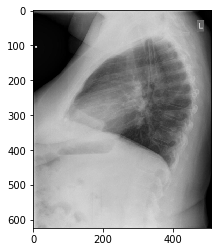

In [61]:
# load image as pixel array
test_image = image.imread(TEST_IMAGE_DIR+'/'+"CXR354_IM-1731-3003.png")
# summarize shape of the pixel array print(data.dtype)
print(test_image.shape)
# display the array of pixels as an image pyplot.imshow(data)
pyplot.show()
pyplot.imshow(test_image)

In [64]:
# Do any preprocessing
x = resize(test_image, (150, 150)) * 255
x = np.expand_dims(x, 0)

prediction = model.predict(x)
# Do any postprocessing
print(prediction.tolist()[0])

[0.0, 1.0]


In [39]:
# Ignore me - tesing with standard model
# preprocess input 
image_size = model.input_shape[1]
x = center_crop_and_resize(test_image, image_size=image_size)
x = preprocess_input(x)
x = np.expand_dims(x, 0)
 
# make prediction and decode
y = model.predict(x)
decode_predictions(y)

[[('n02510455', 'giant_panda', 0.8347932),
  ('n02134084', 'ice_bear', 0.015602044),
  ('n02509815', 'lesser_panda', 0.0045535145),
  ('n02133161', 'American_black_bear', 0.002471914),
  ('n02132136', 'brown_bear', 0.0020707557)]]